# 經典範例：颱風最大風速偵測 採用 深度學習之遷移式學習

- 經過這個範例，預期可以獲取MAE~=1.2的效果，平均最大風速誤判範圍在1.2等級內。

## 載入套件

In [1]:
# TensorFlow是用於機器學習的端對端開放原始碼平台，由各式各樣的工具、程式庫和社群資源所組成，功能完善且具有彈性，可讓研究人員進一步發展機器學習的技術，並讓開發人員輕鬆打造及部署採用機器學習技術的應用程式。
# 請參考：https://www.tensorflow.org/
import tensorflow as tf
# TensorFlow Hub 是已訓練機器學習模型的存放區，這些模型可供微調，也可在任何地方部署。只要幾行程式碼，就能重複使用 BERT 和 Faster R-CNN 等經過訓練的模型。
# 請參考：https://www.tensorflow.org/hub
# 請參考：https://www.tensorflow.org/hub/tutorials
import tensorflow_hub as hub
# NumPy是Python在進行科學運算時，一個非常基礎的Package，同時也是非常核心的library，提供非常高效能的多維陣列(multi-dimensional array)數學函式庫。
import numpy as np
# os模組簡單的來說它是一個Python的系統程式設計的操作模組，可以處理檔案和目錄這些我們日常手動需要做的操作。
import os
# Math模組是Python中常用的數學運算擴充套件。
import math
# glob是python自己带的一个文件操作相关模块，用它可以查找符合自己目的的文件。
from glob import glob
# Datetime 這個模組很好地封裝了Python 關於日期相關的處理
import datetime

# 設定颱風影像資料路浸
root_dir = '/ws_data/CWB/typhoon/Image_B13/'

# 設定程式可以使用的NVIDIA GPU，舉例："0,1"代表第0和第1個GPU可以被使用。如果大於1顆GPU則需要另外處理Multi-GPU的實作，這邊先設定"0"單GPU訓練。
os.environ["CUDA_VISIBLE_DEVICES"]="0"

## 設定超參數(Hyper-Parameters) ##
# 原圖影像為1000x1000這邊目標縮小為224x224，原因是使用的預訓練模型，所訓練的影像資料就是224x224，通常模型在處理相近大小的資料時可以表現更好。
IMG_RESIZE = 224
# Mini-batch訓練是deep learning非常慣用的技巧，這邊設定為每64張影像為一批次(batch)，訓練模型一次(step)。
BATCH_SIZE = 64

## 資料讀取&準備

In [2]:
# 資料讀取&準備
# 請參考：https://www.tensorflow.org/guide/data
# 請參考：https://www.tensorflow.org/tutorials/load_data/images
train_ds = tf.data.Dataset.list_files(os.path.join(root_dir, 'train/*/*'), shuffle=True)
test_ds = tf.data.Dataset.list_files(os.path.join(root_dir, 'test/*/*'), shuffle=True)

# 整理颱風類別
class_names = np.array(sorted([os.path.basename(item) for item in glob(os.path.join(root_dir,'train/*'))]))
num_class = len(class_names)
print(class_names)

# 統計資料樹量
num_train = tf.data.experimental.cardinality(train_ds).numpy()
print(f'num_train: {num_train}')
num_test = tf.data.experimental.cardinality(test_ds).numpy()
print(f'num_test: {num_test}')
STEPS_PER_EPOCH = math.ceil(num_train/BATCH_SIZE)

########
# 定義 #
########

# Preprocessing: 資料前處理，影像資料需先整理成數值資料呈現。
@tf.function
def process_path(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    label = parts[-2] == class_names
    label = tf.math.argmax(label)
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_RESIZE, IMG_RESIZE])
    # Norm
    img = img / 128.0 -1
    return img, label

# Augmentation: 資料強化，增加資料多樣性可以幫助模型學得更通用(robustness)的特徵。
@tf.function
def aug(img, y):
    pad = IMG_RESIZE//8
    img = tf.image.resize_with_crop_or_pad(img, IMG_RESIZE + pad * 2, IMG_RESIZE + pad * 2)
    img = tf.image.random_crop(img, [IMG_RESIZE, IMG_RESIZE, 3])
    img = tf.image.random_flip_left_right(img)
    return img, y

########
# 初始 #
########

# Preprocessing
train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache()
test_ds = test_ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache()
# Augmentation + batching
train_ds = train_ds.map(aug, num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(
        num_train).batch(BATCH_SIZE, drop_remainder=True).repeat().prefetch(
            buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.batch(
    BATCH_SIZE, drop_remainder=False).prefetch(
        buffer_size=tf.data.experimental.AUTOTUNE)

['010' '020' '025' '030' '035' '040' '045' '050' '060' '070' '080' '090'
 '110' '130']
num_train: 1908
num_test: 280


## 建構深度學習分類模型

In [3]:
########
# 定義 #
########

# 建構我們的最終模型，在預先訓練好的模型，BiT-ResNet50之上，增添一層Dense Layer。
# 這是最常見的遷移試學習(Transfer Learning)，請參考：https://www.tensorflow.org/hub/tutorials
class MyBiTModel(tf.keras.Model):
  """BiT with a new head."""

  def __init__(self, module):
    super().__init__()
    self.head = tf.keras.layers.Dense(1, kernel_initializer='zeros')
    self.bit_model = module
  
  def call(self, images):
    bit_embedding = self.bit_model(images)
    return self.head(bit_embedding)

########
# 初始 #
########
    
# 這是要使用預先訓練好的模型，BiT-ResNet50
# 請參考：https://tfhub.dev/google/bit/m-r50x1/1
# 遷移試學習通常會先固定預訓練好的模型`trainable=False`，避免模型訓練初期破換了以前學習的經驗。
# 請參考：https://www.tensorflow.org/tutorials/images/transfer_learning
model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
module = hub.KerasLayer(model_url, trainable=False)

# 初始化模型
model = MyBiTModel(module=module)
model(tf.keras.Input([250,250,3]))
model.summary()

Model: "my_bi_t_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 2049      
_________________________________________________________________
keras_layer (KerasLayer)     (None, 2048)              23500352  
Total params: 23,502,401
Trainable params: 2,049
Non-trainable params: 23,500,352
_________________________________________________________________


## 定義Loss Function, Optimizer以及Callback Function

- Data Preprocessing, Model, Loss Function, Optimizer以及Callback Function等等都是深度學習最基本元素，請參考：https://www.tensorflow.org/tutorials/images/classification

In [5]:
# Optimizer採用Adam，搭配Learning Rate=5e-4
# Loss Funcion採用MSE(MeanSquaredError)
lr = 5e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
loss_fn = tf.keras.losses.MeanSquaredError()

# TensorBoard 提供機器學習實驗所需的視覺化呈現和工具
# 請參考：https://www.tensorflow.org/tensorboard
log_dir = "/results/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

# 請參考：https://www.tensorflow.org/tutorials/keras/save_and_load
checkpoint_filepath = f'{log_dir}/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_mae',
    mode='min',
    save_best_only=True)

# 模型編譯
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=[tf.keras.metrics.MeanAbsoluteError('mae'), tf.keras.metrics.RootMeanSquaredError('rmse')])

# 開始訓練
epochs = 50
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[model_checkpoint_callback, tensorboard_callback],
    epochs=epochs,  
    validation_data=test_ds
)

Epoch 1/50
 1/30 [>.............................] - ETA: 0s - loss: 59.4844 - mae: 6.7031 - rmse: 7.7126WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


Instructions for updating:
use `tf.profiler.experimental.stop` instead.


 2/30 [=>............................] - ETA: 4s - loss: 45.4679 - mae: 5.5602 - rmse: 6.7430WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0339s vs `on_train_batch_end` time: 0.3025s). Check your callbacks.


30/30 [==============================] - 14s 480ms/step - loss: 13.5704 - mae: 2.9442 - rmse: 3.6838 - val_loss: 4.1731 - val_mae: 1.6760 - val_rmse: 2.0428
Epoch 2/50
30/30 [==============================] - 15s 489ms/step - loss: 3.8725 - mae: 1.5891 - rmse: 1.9679 - val_loss: 2.9802 - val_mae: 1.3928 - val_rmse: 1.7263
Epoch 3/50
30/30 [==============================] - 11s 375ms/step - loss: 3.3712 - mae: 1.4513 - rmse: 1.8361 - val_loss: 2.9944 - val_mae: 1.3830 - val_rmse: 1.7304
Epoch 4/50
30/30 [==============================] - 12s 395ms/step - loss: 3.2467 - mae: 1.4274 - rmse: 1.8019 - val_loss: 2.7594 - val_mae: 1.3154 - val_rmse: 1.6611
Epoch 5/50
30/30 [==============================] - 12s 388ms/step - loss: 3.0464 - mae: 1.3912 - rmse: 1.7454 - val_loss: 2.6035 - val_mae: 1.2743 - val_rmse: 1.6135
Epoch 6/50
30/30 [==============================] - 10s 348ms/step - loss: 2.9881 - mae: 1.3589 - rmse: 1.7286 - val_loss: 2.5209 - val_mae: 1.2555 - val_rmse: 1.5877
Epoch 7/

### 評估

In [6]:
model.evaluate(test_ds)

5/5 [==============================] - 1s 132ms/step - loss: 2.5457 - mae: 1.2750 - rmse: 1.5955


[2.545724391937256, 1.2749720811843872, 1.5955326557159424]

### 載入歷史最佳，重新評估

- 請參考：https://www.tensorflow.org/tutorials/keras/save_and_load

In [7]:
model.load_weights(checkpoint_filepath)
model.evaluate(test_ds)

5/5 [==============================] - 1s 134ms/step - loss: 2.4210 - mae: 1.2287 - rmse: 1.5560


[2.4210333824157715, 1.228676438331604, 1.5559669733047485]

### 下一步：fine-tuning 微調模型

- 請參考：https://www.tensorflow.org/tutorials/images/transfer_learning

In [8]:
# 查看全部網路權重學習狀態
for layer in model.layers:
    print(layer.trainable)

True
False


In [9]:
# 設定全部網路權重皆可學習
model.trainable = True
for layer in model.layers:
    print(layer.trainable)

True
True


In [10]:
# 因為現在全部網路權重皆可以學習，網路學習能力非常強，微調的learning rate不用太大
lr = 1e-6
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=[tf.keras.metrics.MeanAbsoluteError('mae'), tf.keras.metrics.RootMeanSquaredError('rmse')])

# 開始學習
tune_epochs = epochs + 50
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[model_checkpoint_callback, tensorboard_callback],
    initial_epoch=epochs, epochs=tune_epochs,
    validation_data=test_ds
)

Epoch 51/100
 2/30 [=>............................] - ETA: 55s - loss: 3.1351 - mae: 1.4095 - rmse: 1.7706WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.3093s vs `on_train_batch_end` time: 3.6748s). Check your callbacks.


30/30 [==============================] - 31s 1s/step - loss: 2.5933 - mae: 1.2628 - rmse: 1.6104 - val_loss: 2.3708 - val_mae: 1.2145 - val_rmse: 1.5397
Epoch 52/100
30/30 [==============================] - 26s 875ms/step - loss: 2.5892 - mae: 1.2477 - rmse: 1.6091 - val_loss: 2.3315 - val_mae: 1.2090 - val_rmse: 1.5269
Epoch 53/100
30/30 [==============================] - 25s 834ms/step - loss: 2.4288 - mae: 1.2142 - rmse: 1.5585 - val_loss: 2.2991 - val_mae: 1.2009 - val_rmse: 1.5163
Epoch 54/100
30/30 [==============================] - 25s 828ms/step - loss: 2.4192 - mae: 1.2022 - rmse: 1.5554 - val_loss: 2.2951 - val_mae: 1.1986 - val_rmse: 1.5149
Epoch 55/100
30/30 [==============================] - 14s 472ms/step - loss: 2.3219 - mae: 1.1810 - rmse: 1.5238 - val_loss: 2.2886 - val_mae: 1.2081 - val_rmse: 1.5128
Epoch 56/100
30/30 [==============================] - 26s 864ms/step - loss: 2.1892 - mae: 1.1467 - rmse: 1.4796 - val_loss: 2.2747 - val_mae: 1.1924 - val_rmse: 1.5082
Ep

### 評估

In [11]:
model.evaluate(test_ds)

5/5 [==============================] - 1s 133ms/step - loss: 2.4036 - mae: 1.2216 - rmse: 1.5504


[2.403592348098755, 1.2216129302978516, 1.5503523349761963]

### 載入歷史最佳，重新評估

In [12]:
model.load_weights(checkpoint_filepath)
model.evaluate(test_ds)

5/5 [==============================] - 1s 132ms/step - loss: 2.2342 - mae: 1.1800 - rmse: 1.4947


[2.2341837882995605, 1.179978370666504, 1.4947186708450317]

## 總整理：目前歷史最佳訓練結果

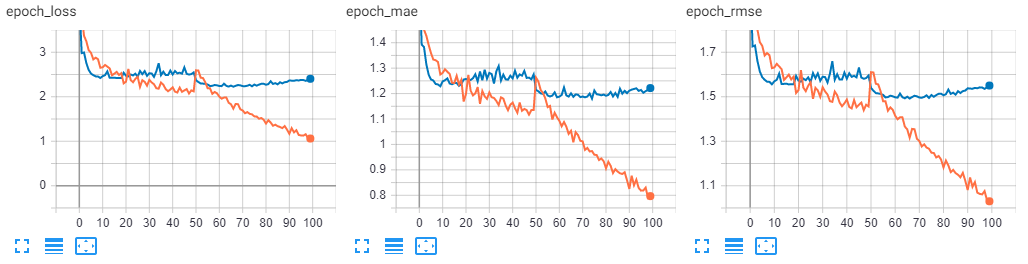

- `mae`: 1.1800
- `rmse`: 1.4947

### 練習：或許你可以試試以下實驗，獲取更好或更糟的結果？

- What if we don’t fixed pretrained model and train the whole model directly?
- What if no transfer learning?
- Larger/Smaller learning rate?
- Larger/Smaller batch size?
- Change loss from MSE to MAE?
    - What’s else?
    - Data Augmentation?
    - Weight Decay?
    - Drop Out?
    - Use Cross Entropy?
    - …
- Could you get training even faster?
    - Optimize data pipeline?
    - Mixed Precision?
    - Multi-GPUs?
    - DALI?
    - ...